# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from IPython.display import display, clear_output

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline
%config InlineBackend.figure_formats = ['png2x']


import pyaldata as pyal
import defs

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
    reload (defs)
finally:
    os.chdir(nbPath)

print('Done')

Done


---

#### Load the lower bound values for the canonical correlations

takes a couple of minutes to execute.

In [2]:
%run "_mouse-lower-bound.ipynb"

variables: `CC_lower_bound_M1` and `CC_lower_bound_Str` hold the lower bound correlations


---

#### Load the upper bound values for the canonical correlations

takes a couple of minutes to execute.

In [3]:
%run "_mouse-upper-bound.ipynb"

variables: `CC_upper_bound_M1` and `CC_upper_bound_Str` hold the upper bound correlations


# reading data

In [4]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root/animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

---

# CCA comparison

## 2 mice, same epoch

load the data

In [5]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=8
min_time=17
min_trials_=8
min_time_=17


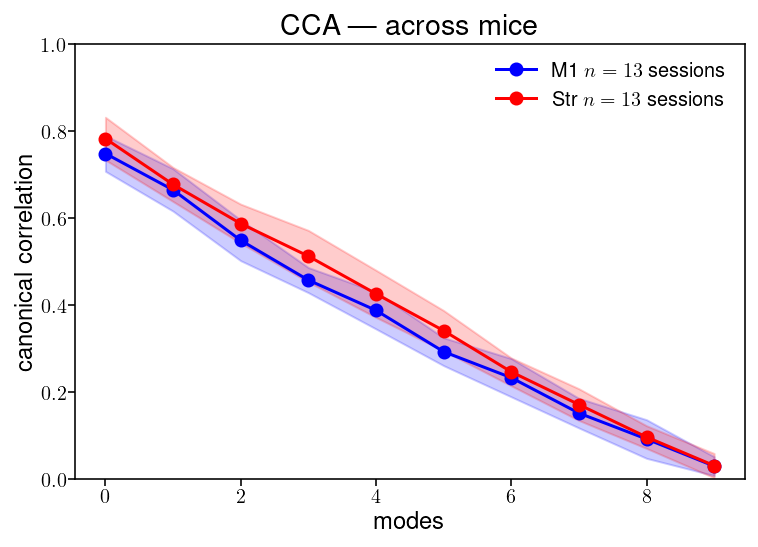

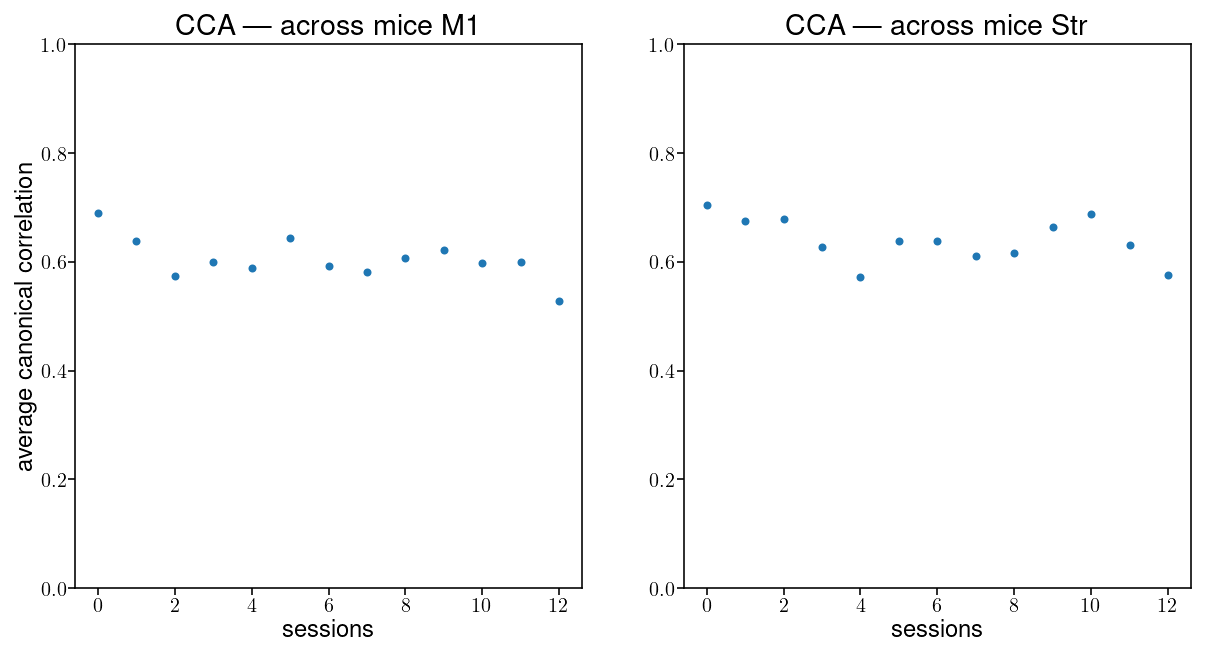

In [6]:
side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, exec_epoch, area=areas[0], model=n_components)
AllData2 = dt.get_data_array(side2df, exec_epoch, area=areas[0], model=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

side1df = [allDFs_Str[i] for i,_ in pairFileList2]
side2df = [allDFs_Str[j] for _,j in pairFileList2]
AllData1_ = dt.get_data_array(side1df, exec_epoch, area=areas[1], model=n_components)
AllData2_ = dt.get_data_array(side2df, exec_epoch, area=areas[1], model=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')
warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    allCCs1.append(dt.canoncorr(data1, data2))
allCCs1 = np.array(allCCs1).T

# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={allCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={allCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('modes')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across mice', usetex=True);

_,axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(allCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(allCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- across mice {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')


### Overall Figures

across monkey and within monkey together

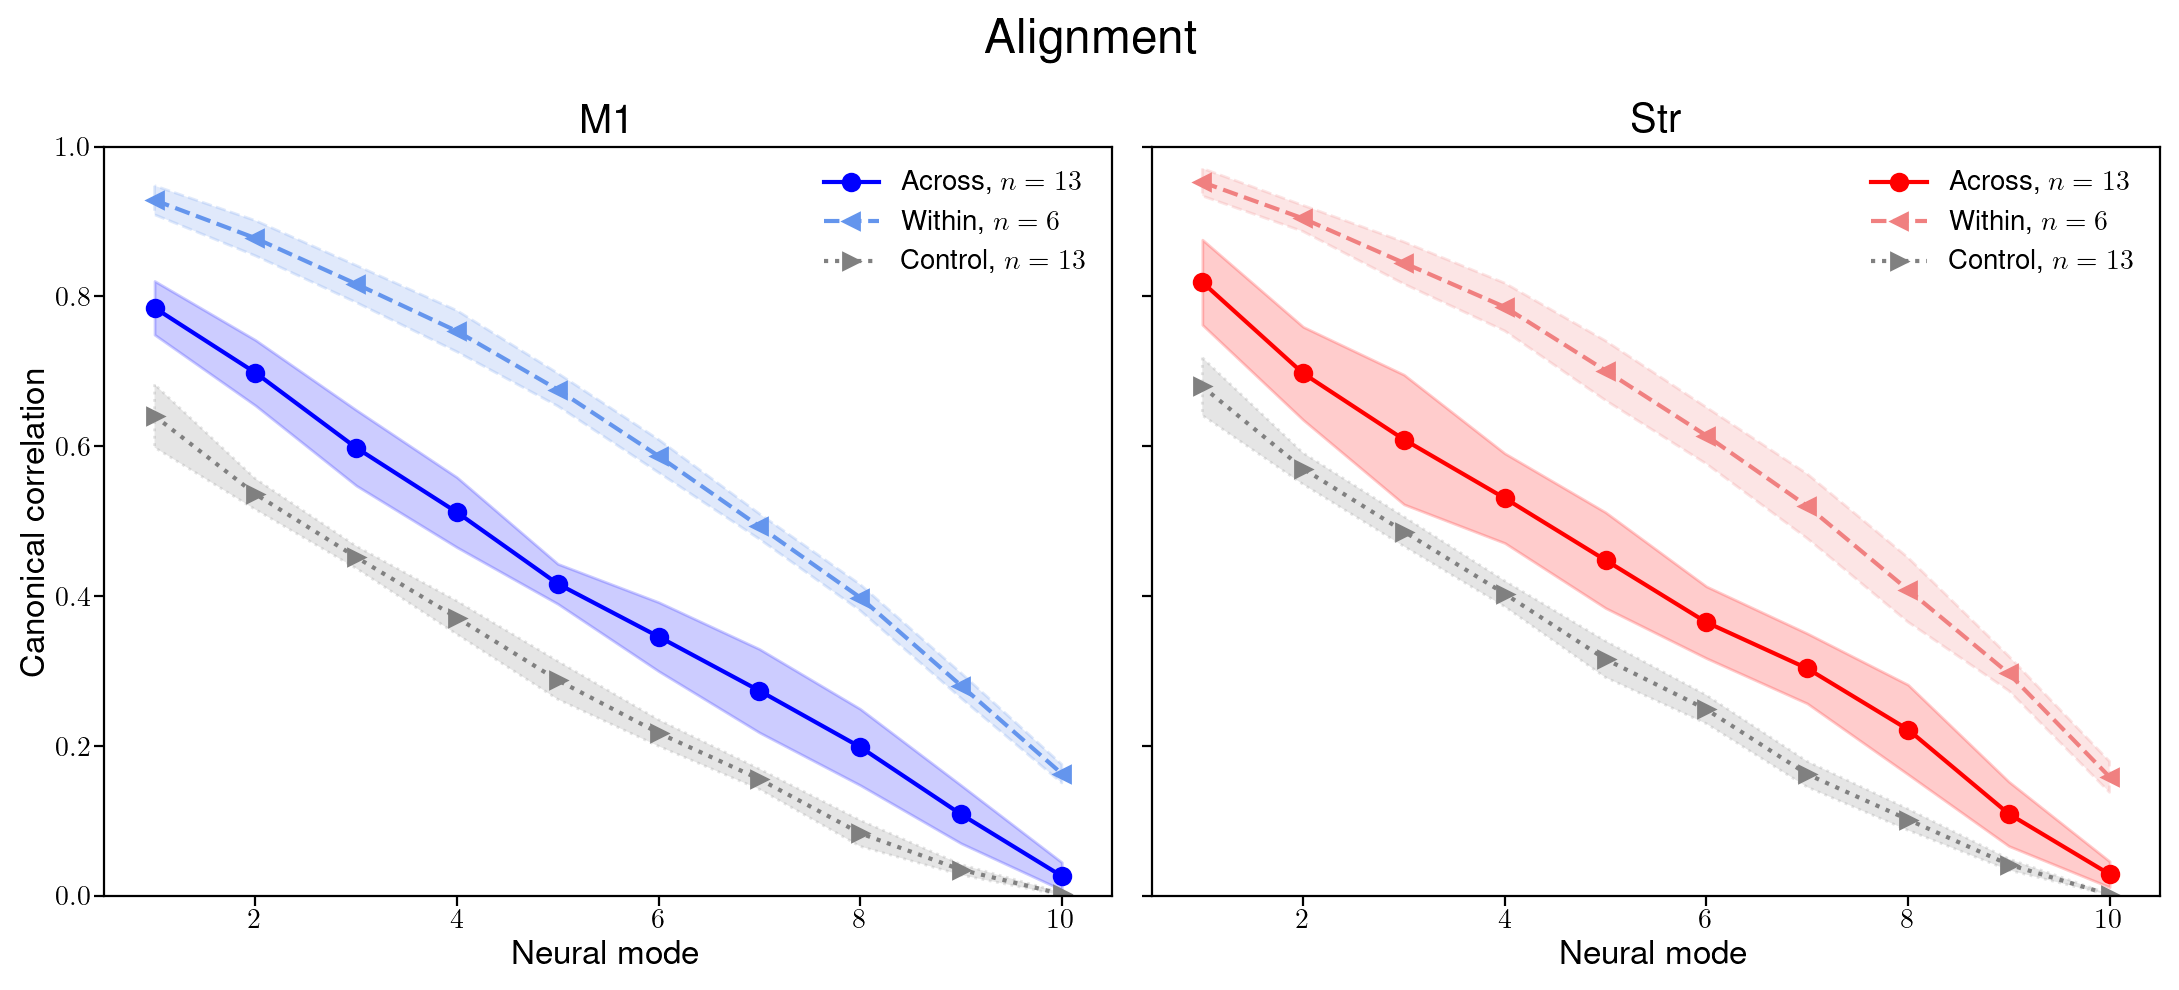

In [8]:
# plot
fig,axes = plt.subplots(ncols=2, figsize=(11,5), dpi=100, sharey=True, sharex=True)

utility.shaded_errorbar(axes[0], np.arange(1,n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')
utility.shaded_errorbar(axes[1], np.arange(1,n_components+1), allCCs1, color='r', marker = 'o', label=f'Across, $n={allCCs1.shape[1]}$')

utility.shaded_errorbar(axes[0], np.arange(1,n_components+1), CC_upper_bound_M1, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_M1.shape[1]}$')
utility.shaded_errorbar(axes[1], np.arange(1,n_components+1), CC_upper_bound_Str, color='lightcoral', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_Str.shape[1]}$')

utility.shaded_errorbar(axes[0], np.arange(1,n_components+1), CC_lower_bound_M1, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_M1.shape[1]}$')
utility.shaded_errorbar(axes[1], np.arange(1,n_components+1), CC_lower_bound_Str, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_Str.shape[1]}$')


for i,ax in enumerate(axes):
    ax.set_ylim([0,1])
    ax.set_xlim([.5,n_components+.5])
    ax.set_xlabel('Neural mode')
    ax.set_title(f'{areas[i]}')
    ax.legend()
axes[0].set_ylabel('Canonical correlation')
fig.suptitle('Alignment', fontsize = 'xx-large');
fig.tight_layout()

comapring group correlations
>Like the NN paper, _Fig. 4e_.

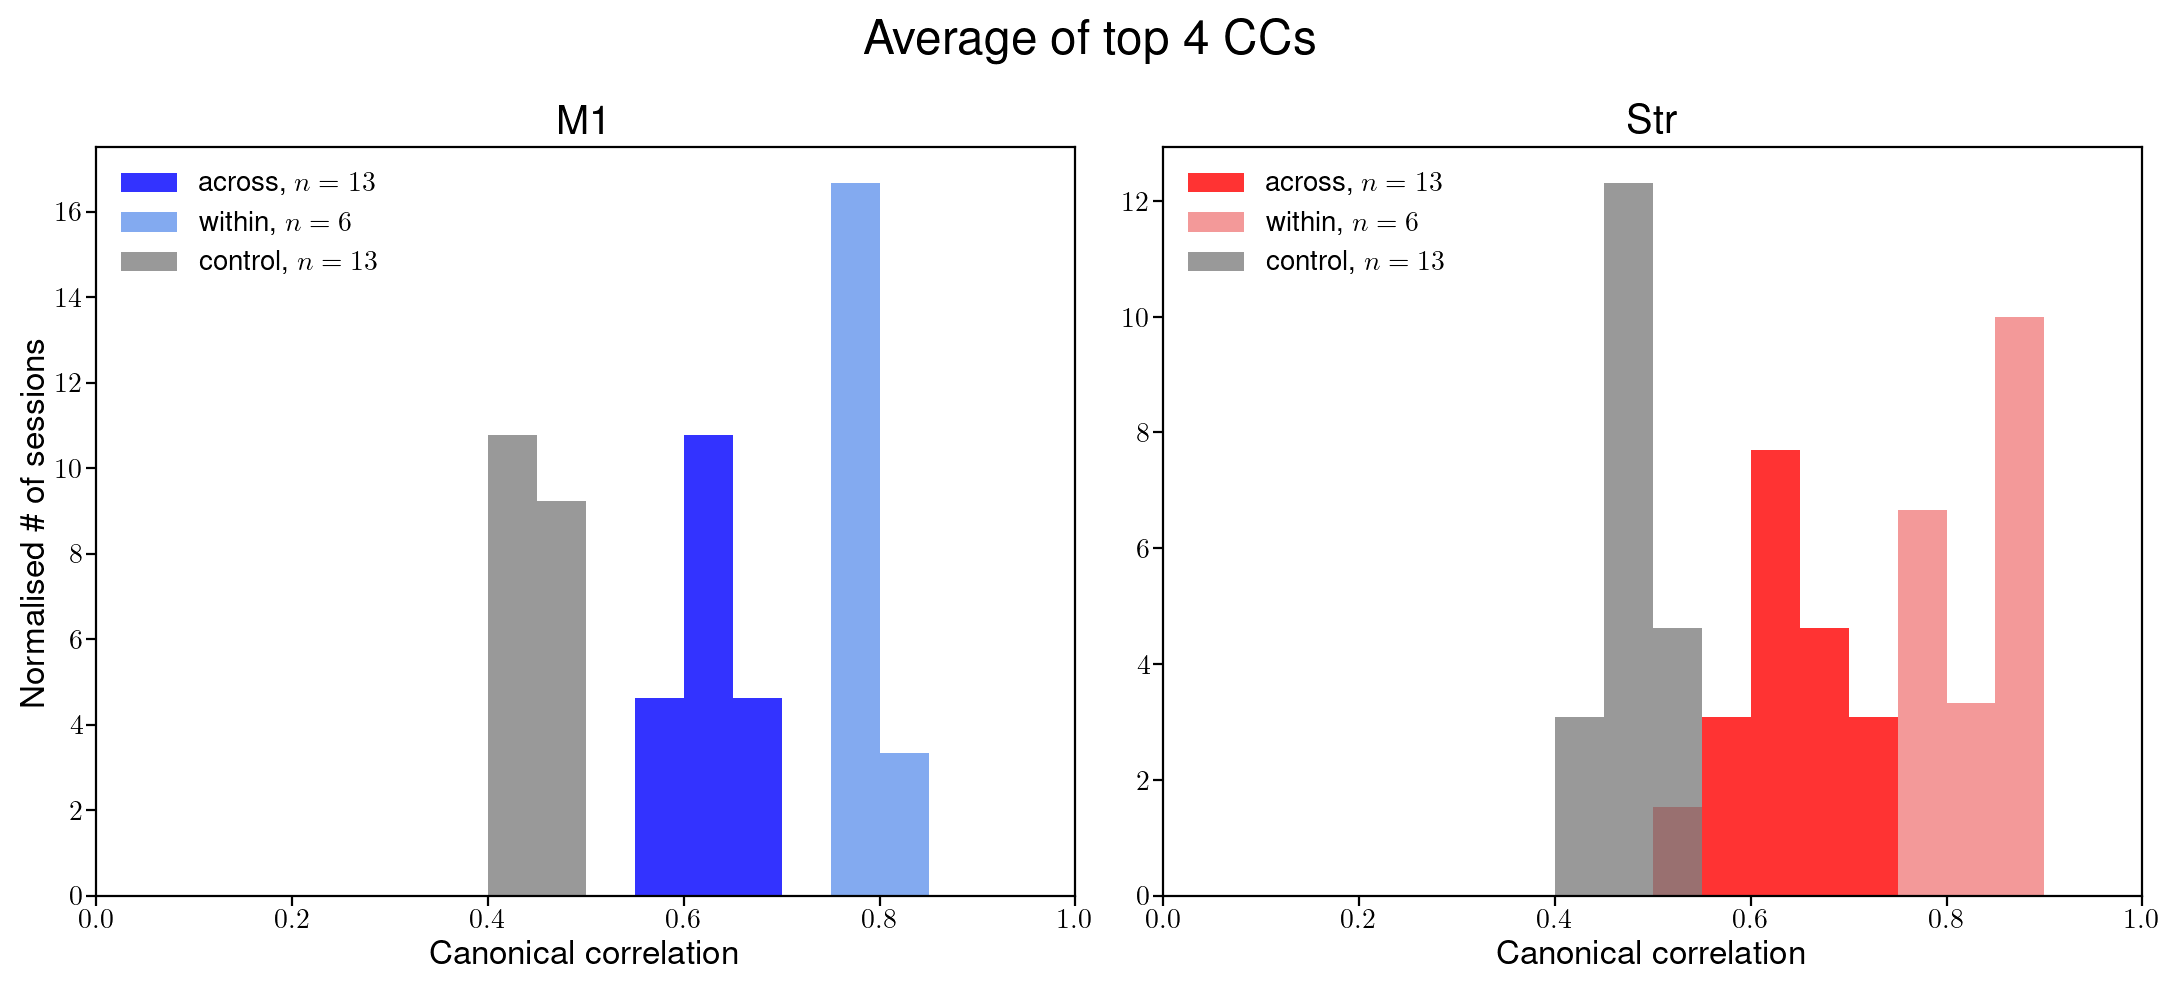

In [8]:
fig,axes = plt.subplots(ncols=2, figsize=(11,5), dpi=100)
bins = np.arange(0,1,0.05)
ax = axes[0]
ax.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True,
        color='b', alpha=.8, label=f'across, $n={allCCs0[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_upper_bound_M1[:4,:].mean(axis=0), bins=bins, density=True,
        color='cornflowerblue', alpha=.8, label=f'within, $n={CC_upper_bound_M1[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_lower_bound_M1[:4,:].mean(axis=0), bins=bins, density=True,
        color='gray', alpha=.8, label=f'control, $n={CC_lower_bound_M1[:4,:].mean(axis=0).shape[0]}$')
ax = axes[1]
ax.hist(allCCs1[:4,:].mean(axis=0), bins=bins, density=True,
        color='r', alpha=.8, label=f'across, $n={allCCs1[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_upper_bound_Str[:4,:].mean(axis=0), bins=bins, density=True,
        color='lightcoral', alpha=.8, label=f'within, $n={CC_upper_bound_Str[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_lower_bound_Str[:4,:].mean(axis=0), bins=bins, density=True,
        color='gray', alpha=.8, label=f'control, $n={CC_lower_bound_Str[:4,:].mean(axis=0).shape[0]}$')

for i,ax in enumerate(axes):
    ax.set_title(f'{areas[i]}')
    ax.set_xlim([0,1])
    ax.set_xlabel('Canonical correlation')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.legend(loc=2)
axes[0].set_ylabel(r'Normalised \# of sessions')
fig.suptitle('Average of top 4 CCs', fontsize = 'xx-large')
fig.tight_layout()

---

## one mouse, 2 epochs

as an extra control

In [ ]:
warnings.filterwarnings("ignore")
side1df = allDFs_M1
AllData1 = dt.get_data_array(side1df, fixation_epoch, area=areas[0], model=n_components)
AllData2 = dt.get_data_array(side1df, exec_epoch, area=areas[0], model=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

# PMd
side2df = allDFs_Str
AllData1_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], model=n_components)
AllData2_ = dt.get_data_array(side2df, exec_epoch, area=areas[1], model=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    inCCs0.append(dt.canoncorr(data1, data2))
inCCs0 = np.array(inCCs0).T

inCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    inCCs1.append(dt.canoncorr(data1, data2))
inCCs1 = np.array(inCCs1).T
warnings.filterwarnings("default")

# plotting
_,ax = plt.subplots()

utility.shaded_errorbar(ax, inCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={inCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, inCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={inCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- within mouse', usetex=True);

fig,axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(inCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(inCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- within mouse {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')

---

# VAF?

In [ ]:
def get_unit_data_and_pca(data_list: list[pd.DataFrame], epoch , area: str ='M1', n_components: int =10) -> tuple[np.ndarray, sklearn.decomposition._pca.PCA]:
    """
    Applies PCA to the data and return a data matrix of the shape: sessions x targets x  trials x time x PCs
    with the minimum number of trials and timepoints shared across all the datasets/targets.
    
    Parameters
    ----------
    `data_list`: list of pd.dataFrame datasets from pyal-data
    `epoch`: an epoch function of the type `pyal.generate_epoch_fun`
    `area`: area, either: 'M1', or 'S1', or 'PMd'

    Returns
    -------
    `AllData`: np.array
    `AllPCA`: list of pca objects of each session

    Signature
    -------
    AllData = get_data_array(data_list, execution_epoch, area='M1', n_components=10)
    all_data = np.reshape(AllData, (-1,10))
    """
    field = f'{area}_rates'
    n_shared_trial = np.inf
    n_unit = np.inf
    for df in data_list:
        n_unit = np.min((df[field][0].shape[1], n_unit))
        for target in range(8):
            df_ = pyal.select_trials(df, df.target_id== target)
            n_shared_trial = np.min((df_.shape[0], n_shared_trial))

    n_shared_trial = int(n_shared_trial)
    n_unit = int(n_unit)

    # finding the number of timepoints
    df_ = pyal.restrict_to_interval(df_,epoch_fun=epoch)
    n_timepoints = int(df_[field][0].shape[0])

    # pre-allocating the data matrix
    AllData = np.empty((len(data_list), 8, n_shared_trial, n_timepoints, n_unit))
    AllPCA = []
    for session, df in enumerate(data_list):
        df_ = pyal.restrict_to_interval(df, epoch_fun=epoch)
        rates = np.concatenate(df_[field].values, axis=0)
        rates -= np.mean(rates, axis=0)
        all_units = np.arange(rates.shape[1])
        params.rng.shuffle(all_units)
        rates_model = PCA(n_components=n_components, svd_solver='full').fit(rates[:,all_units[:n_unit]])
        AllPCA.append(rates_model)
        
        for target in range(8):
            df__ = pyal.select_trials(df_, df_.target_id==target)
            all_id = df__.trial_id.to_numpy()
            params.rng.shuffle(all_id)
            # select the right number of trials to each target
            df__ = pyal.select_trials(df__, lambda trial: trial.trial_id in all_id[:n_shared_trial])
            for trial, trial_rates in enumerate(df__[field]):
                AllData[session,target,trial, :, :] = trial_rates [:,all_units[:n_unit]]
    
    return AllData, AllPCA


## 2 monkeys, same epoch

In [ ]:
warnings.filterwarnings("ignore")
pairFileList1 = []
for I, animal1 in enumerate(GoodDataList[areas[0]]):
    for J, animal2 in enumerate(GoodDataList[areas[0]]):
        if J<=I or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[0]][animal2][i] for i,_ in enumerate(GoodDataList[areas[0]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList1.append((df1, dt.load_pyal_data(path2)))


gc.collect()
pairFileList_area0 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList1]
del pairFileList1
gc.collect()
warnings.filterwarnings("default")

side1df = [df for df,_ in pairFileList_area0]
side2df = [df for _,df in pairFileList_area0]
AllData1, AllPca1 = get_unit_data_and_pca(side1df, exec_epoch, area=areas[0], n_components=n_components)
AllData2, AllPca2 = get_unit_data_and_pca(side2df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time, _ = np.min((AllData1.shape,AllData2.shape),axis=0)


allVAFs=[]
for sessionData1,sessionData2, model1, model2 in zip(AllData1, AllData2, AllPca1, AllPca2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,sessionData1.shape[-1]))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,sessionData2.shape[-1]))
    A, B, *_ = dt.canoncorr(model1.transform(data1), model2.transform(data2), fullReturn=True)
    allVAFs.append(dt.VAF_pc_cc(X=data1, C=model1.components_, A=A)+dt.VAF_pc_cc(X=data2, C=model2.components_, A=B))
allVAFs = np.cumsum(np.array(allVAFs).T /2, axis=0)


# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, allVAFs, color='b', marker = 'o', label=f'{areas[0]} $n={allVAFs.shape[1]}$ sessions')
ax.plot(allVAFs,lw=1, alpha=.3);
ax.set_ylim([0,1])
ax.set_xlabel('axes')
ax.legend()
ax.set_ylabel('VAF')
ax.set_title('VAF --- M1 across monkeys', usetex=True);

In [ ]:
warnings.filterwarnings("ignore")
pairFileList2 = []
for I, animal1 in enumerate(GoodDataList[areas[1]]):
    for J, animal2 in enumerate(GoodDataList[areas[1]]):
        if J<=I or '2' in animal1+animal2:  # to repetitions and to remove Chewie2
            continue
        path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
        path2List = [root/animal2/GoodDataList[areas[1]][animal2][i] for i,_ in enumerate(GoodDataList[areas[1]][animal2])]
        for path1 in path1List:
            df1 = dt.load_pyal_data(path1)
            for path2 in path2List:
                pairFileList2.append((df1, dt.load_pyal_data(path2)))


gc.collect()
pairFileList_area1 = [(prep_general(df1),prep_general(df2)) for  df1,df2 in pairFileList2]
del pairFileList2
gc.collect()
warnings.filterwarnings("default")

side1df = [df for df,_ in pairFileList_area1]
side2df = [df for _,df in pairFileList_area1]
AllData1, AllPca1 = get_unit_data_and_pca(side1df, exec_epoch, area=areas[1], n_components=n_components)
AllData2, AllPca2 = get_unit_data_and_pca(side2df, exec_epoch, area=areas[1], n_components=n_components)
_,_, min_trials, min_time, _ = np.min((AllData1.shape,AllData2.shape),axis=0)


allVAFs2=[]
for sessionData1,sessionData2, model1, model2 in zip(AllData1, AllData2, AllPca1, AllPca2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,sessionData1.shape[-1]))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,sessionData2.shape[-1]))
    A, B, *_ = dt.canoncorr(model1.transform(data1), model2.transform(data2), fullReturn=True)
    allVAFs2.append(dt.VAF_pc_cc(X=data1, C=model1.components_, A=A)+dt.VAF_pc_cc(X=data2, C=model2.components_, A=B))
allVAFs2 = np.cumsum(np.array(allVAFs2).T / 2, axis=0)


# plot
_,ax = plt.subplots()
utility.shaded_errorbar(ax, allVAFs2, color='b', marker = 'o', label=f'{areas[1]} $n={allVAFs.shape[1]}$ sessions')
ax.plot(allVAFs2,lw=1, alpha=.3);
ax.set_ylim([0,1])
ax.set_xlabel('axes')
ax.legend()
ax.set_ylabel('VAF')
ax.set_title('VAF --- PMd across monkeys', usetex=True);

## one monkey, two epochs

In [ ]:
pairFileList1 = []
for animal1 in GoodDataList[areas[0]]:
    path1List = [root/animal1/GoodDataList[areas[0]][animal1][i] for i,_ in enumerate(GoodDataList[areas[0]][animal1])]
    for path1 in path1List:
        df1 = dt.load_pyal_data(path1)
        pairFileList1.append(df1)

print(f'{len(pairFileList1)=}')

pairFileList2 = []
for animal1 in GoodDataList[areas[1]]:
    path1List = [root/animal1/GoodDataList[areas[1]][animal1][i] for i,_ in enumerate(GoodDataList[areas[1]][animal1])]
    for path1 in path1List:
        df1 = dt.load_pyal_data(path1)
        pairFileList2.append(df1)

warnings.filterwarnings("ignore")
gc.collect()
pairFileList_area0 = [prep_general(df) for df in pairFileList1]
del pairFileList1
gc.collect()
pairFileList_area1 = [prep_general(df) for  df in pairFileList2]
del pairFileList2
gc.collect()


side1df = pairFileList_area0
AllData1, AllPca1 = get_unit_data_and_pca(side1df, prep_epoch, area=areas[0], n_components=n_components)
AllData2, AllPca2 = get_unit_data_and_pca(side1df, exec_epoch, area=areas[0], n_components=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')
# PMd
side2df = pairFileList_area1
AllData1_, AllPca1_ = get_unit_data_and_pca(side2df, prep_epoch, area=areas[1], n_components=n_components)
AllData2_, AllPca2_ = get_unit_data_and_pca(side2df, exec_epoch, area=areas[1], n_components=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')

inVAFs0=[]
for sessionData1,sessionData2,model1,model2 in zip(AllData1,AllData2,AllPca1,AllPca2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,sessionData1.shape[-1]))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,sessionData2.shape[-1]))
    A, B, *_ = dt.canoncorr(model1.transform(data1), model2.transform(data2), fullReturn=True)
    inVAFs0.append(dt.VAF_pc_cc(X=data1, C=model1.components_, A=A)+dt.VAF_pc_cc(X=data2, C=model2.components_, A=B))
inVAFs0 = np.cumsum(np.array(inVAFs0).T / 2, axis=0)

inVAFs1=[]
for sessionData1,sessionData2,model1,model2 in zip(AllData1_,AllData2_,AllPca1_,AllPca2_):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,sessionData1.shape[-1]))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,sessionData2.shape[-1]))
    A, B, *_ = dt.canoncorr(model1.transform(data1), model2.transform(data2), fullReturn=True)
    inVAFs1.append(dt.VAF_pc_cc(X=data1, C=model1.components_, A=A)+dt.VAF_pc_cc(X=data2, C=model2.components_, A=B))
inVAFs1 = np.cumsum(np.array(inVAFs1).T / 2, axis=0)
warnings.filterwarnings("default")


# plotting
_,ax = plt.subplots()

utility.shaded_errorbar(ax, inVAFs0, color='b', marker = 'o', label=f'{areas[0]} $n={inVAFs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, inVAFs1, color='r', marker = 'o', label=f'{areas[1]} $n={inVAFs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('axes')
ax.legend()
ax.set_ylabel('VAF')
ax.set_title('VAF --- within monkeys', usetex=True);

fig,axes = plt.subplots(ncols=2, figsize=(10,5))
utility.shaded_errorbar(axes[0], allVAFs, color='b', marker = 'o', label=f'Across monkeys $n={allVAFs.shape[1]}$ sessions')
utility.shaded_errorbar(axes[0], inVAFs0, color='r', marker = 'o', label=f'Within monkeys $n={inVAFs0.shape[1]}$ sessions')
utility.shaded_errorbar(axes[1], allVAFs2, color='b', marker = 'o', label=f'Across monkeys $n={allVAFs2.shape[1]}$ sessions')
utility.shaded_errorbar(axes[1], inVAFs1,  color='r', marker = 'o', label=f'Within monkeys $n={inVAFs1.shape[1]}$ sessions')

axes[0].set_ylabel('average VAF')
for i, ax in enumerate(axes):
    ax.set_title(f'VAF --- {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('CC axes')
    ax.legend()